####**SKENARIO 4 SKRIPSI**

**SPLIT DATA 80:20**

**AUGMENTASI OFFLINE**

**BATCH SIZE KLASIFIKASI 16 & 32**

**MENGGUNAKAN RS-UNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path folder ALPUKAT di Google Drive
project_path = '/content/drive/MyDrive/alpukat/dataset'
os.chdir(project_path)

# Verifikasi isi folder
!ls

best_class1_rsunet01.h5  best_rsunet8_model.h5	 maskedrsunet8_train
best_class1_rsunet1.h5	 best_unet01_model.h5	 maskedunet01_test
best_class1_rsunet2.h5	 best_unet1_model.h5	 maskedunet01_train
best_class1_rsunet7.h5	 best_unet2_model.h5	 maskedunet1_train
best_class1_rsunet8.h5	 best_unet3_model.h5	 maskedunet2_test
best_class1_unet01.h5	 best_unet4_model.h5	 maskedunet2_train
best_class1_unet1.h5	 images			 maskedunet3_test
best_class1_unet2.h5	 images_aug		 maskedunet3_train
best_class1_unet3.h5	 images_augment		 maskedunet4_test
best_class2_rsunet01.h5  labels_converted.csv	 maskedunet4_train
best_class2_rsunet1.h5	 labels.csv		 masks
best_class2_rsunet2.h5	 labels.gsheet		 masks_aug
best_class2_rsunet7.h5	 logs			 masks_augment
best_class2_rsunet8.h5	 maskedrsunet01_test	 model.ipynb
best_class2_unet01.h5	 maskedrsunet01_train	 training_history1.json
best_class2_unet1.h5	 maskedrsunet1_test	 training_history2.json
best_class2_unet3.h5	 maskedrsunet1_train	 training_history3.json

In [ ]:
pip install tensorflow

In [ ]:
# import tensorflow as tf
# import glob
# import os
# from PIL import Image

# # Path input dan output
# image_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/images/*.*'))
# mask_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/masks/*.*'))

# output_img_dir = '/content/drive/MyDrive/alpukat/dataset/images_aug'
# output_mask_dir = '/content/drive/MyDrive/alpukat/dataset/masks_aug'
# os.makedirs(output_img_dir, exist_ok=True)
# os.makedirs(output_mask_dir, exist_ok=True)

# IMG_SIZE = 128

# def resize_with_padding(image, target_size=128):
#     image = tf.image.convert_image_dtype(image, tf.float32)
#     resized = tf.image.resize_with_pad(image, target_size, target_size)
#     resized = tf.image.convert_image_dtype(resized, tf.uint8)
#     return resized

# def load_image(path, channels=3):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_image(img, channels=channels, expand_animations=False)
#     img = resize_with_padding(img, IMG_SIZE)
#     img.set_shape([IMG_SIZE, IMG_SIZE, channels])
#     return img

# def save_tensor_image(tensor, path):
#     if tensor.shape[-1] == 1:
#         tensor = tf.image.grayscale_to_rgb(tensor)
#     img = tf.cast(tensor, tf.uint8).numpy()
#     Image.fromarray(img).save(path, format='JPEG')

# def augment_custom(image, mask):
#     versions = []
#     labels = []

#     for k, angle in enumerate([0, 1, 2, 3]):  # rotasi 0, 90, 180, 270
#         img_rot = tf.image.rot90(image, k=k)
#         mask_rot = tf.image.rot90(mask, k=k)

#         versions.append((img_rot, mask_rot))
#         labels.append(f"rot{90*k}")

#         versions.append((tf.image.flip_left_right(img_rot), tf.image.flip_left_right(mask_rot)))
#         labels.append(f"rot{90*k}_fliph")

#         versions.append((tf.image.flip_up_down(img_rot), tf.image.flip_up_down(mask_rot)))
#         labels.append(f"rot{90*k}_flipv")

#     # Tambahkan hanya satu transpose (tanpa flip)
#     img_trans = tf.image.transpose(image)
#     mask_trans = tf.image.transpose(mask)
#     versions.append((img_trans, mask_trans))
#     labels.append("transpose")

#     return versions, labels

# counter = 0

# for i in range(len(image_paths)):
#     img = load_image(image_paths[i], channels=3)
#     mask = load_image(mask_paths[i], channels=1)

#     base_name = os.path.splitext(os.path.basename(image_paths[i]))[0]

#     aug_versions, aug_labels = augment_custom(img, mask)

#     for (aug_img, aug_mask), label in zip(aug_versions, aug_labels):
#         img_name = f"{base_name}_{label}.jpg"
#         mask_name = f"{base_name}_{label}.jpg"
#         save_tensor_image(aug_img, os.path.join(output_img_dir, img_name))
#         save_tensor_image(aug_mask, os.path.join(output_mask_dir, mask_name))
#         counter += 1

# print(f"{counter} augmented image-mask pairs saved.")


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
import glob
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, SparseCategoricalAccuracy
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input, GlobalAveragePooling2D, Reshape, Dense, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [ ]:
image_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/images_aug/*.*'))  # Untuk semua tipe gambar
mask_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/masks_aug/*.*'))

print(len(image_paths))
print(len(mask_paths))

5850
5850


In [ ]:
label_map = {
    0: "miki",
    1: "aligator",
    2: "marcus"
}

# Jika kamu ingin tetap mendapatkan label numerik, kamu perlu membalik mapping-nya:
reverse_label_map = {v: k for k, v in label_map.items()}
labels = [reverse_label_map[os.path.basename(path).split('_')[0]] for path in image_paths]

In [ ]:
# Gunakan stratified split untuk menjaga proporsi kelas tetap
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_labels, test_labels = train_test_split(
    image_paths, mask_paths, labels,
    test_size=0.2,
    stratify=labels,   # menjaga distribusi kelas
    random_state=42
)


In [ ]:
from collections import Counter

# Hitung jumlah masing-masing label di data training
label_counts = Counter(train_labels)

# Tampilkan hasilnya
for label, count in label_counts.items():
    print(f"Label {label}: {count} data")


Label 2: 1560 data
Label 1: 1560 data
Label 0: 1560 data


##**DATA PREPROCESSING DAN AUGMENTASI**##

In [ ]:
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0

    # Thresholding untuk membentuk mask biner
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

In [ ]:
# Dataset untuk train
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16

train_unet_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_unet_ds = train_unet_ds.map(lambda image_path, mask_path: load_and_preprocess_image(image_path, mask_path),
                                  num_parallel_calls=AUTOTUNE)
train_unet_ds = train_unet_ds.shuffle(100).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Dataset untuk test
test_unet_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_unet_ds = test_unet_ds.map(lambda image_path, mask_path: load_and_preprocess_image(image_path, mask_path),
                                num_parallel_calls=AUTOTUNE)
test_unet_ds = test_unet_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

##**RS-UNET + SE MODEL**##

In [ ]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def squeeze_excite_block(input, ratio=8):
    filters = input.shape[-1]
    se = GlobalAveragePooling2D()(input)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)
    x = Multiply()([input, se])
    return x

def build_resnet50_unet_se(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    # Encoder dengan SE Block
    s1 = resnet50.get_layer("conv1_relu").output        ## (64 x 64)
    s1 = squeeze_excite_block(s1)

    s2 = resnet50.get_layer("conv2_block3_out").output  ## (32 x 32)
    s2 = squeeze_excite_block(s2)

    s3 = resnet50.get_layer("conv3_block4_out").output  ## (16 x 16)
    s3 = squeeze_excite_block(s3)

    s4 = resnet50.get_layer("conv4_block6_out").output  ## (8 x 8)
    s4 = squeeze_excite_block(s4)

    # Decoder
    d1 = decoder_block(s4, s3, 512)                     ## (16 x 16)
    d2 = decoder_block(d1, s2, 256)                     ## (32 x 32)
    d3 = decoder_block(d2, s1, 128)                     ## (64 x 64)
    d4 = decoder_block(d3, inputs, 64)                  ## (128 x 128)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="ResNet50_U-Net_SE")
    return model

# Build and summarize model
model = build_resnet50_unet_se(input_shape=(128, 128, 3))
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "ResNet50_U-Net_SE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 21,021,633 (80.19 MB)

 Trainable params: 20,987,201 (80.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Menggunakan threshold 0.5 untuk prediksi
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [ ]:
# Kompilasi model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Ganti dengan IoU loss jika sudah didefinisikan
    metrics=[iou_metric]
)

# Definisikan callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_rsunet01_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]

In [ ]:
# Melatih model
history = model.fit(
    train_unet_ds,
    epochs=100,
    validation_data=test_unet_ds,
    steps_per_epoch=len(train_unet_ds),
    validation_steps=len(test_unet_ds),
    callbacks=callbacks
)


Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - iou_metric: 0.8771 - loss: 0.0982

293/293 ━━━━━━━━━━━━━━━━━━━━ 1398s 4s/step - iou_metric: 0.8772 - loss: 0.0981 - val_iou_metric: 0.1948 - val_loss: 8.2190
Epoch 2/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - iou_metric: 0.9585 - loss: 0.0214

293/293 ━━━━━━━━━━━━━━━━━━━━ 112s 241ms/step - iou_metric: 0.9586 - loss: 0.0214 - val_iou_metric: 0.3647 - val_loss: 0.8230
Epoch 3/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - iou_metric: 0.9677 - loss: 0.0157

293/293 ━━━━━━━━━━━━━━━━━━━━ 84s 243ms/step - iou_metric: 0.9677 - loss: 0.0157 - val_iou_metric: 0.5672 - val_loss: 0.6895
Epoch 4/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - iou_metric: 0.9597 - loss: 0.0200

293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 241ms/step - iou_metric: 0.9597 - loss: 0.0200 - val_iou_metric: 0.9704 - val_loss: 0.0149
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - iou_metric: 0.9750 - loss: 0.0118

293/293 ━━━━━━━━━━━━━━━━━━━━ 79s 223ms/step - iou_metric: 0.9750 - loss: 0.0118 - val_iou_metric: 0.9714 - val_loss: 0.0137
Epoch 6/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 80s 224ms/step - iou_metric: 0.9748 - loss: 0.0121 - val_iou_metric: 0.9189 - val_loss: 0.1187
Epoch 7/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - iou_metric: 0.9680 - loss: 0.0158

293/293 ━━━━━━━━━━━━━━━━━━━━ 78s 219ms/step - iou_metric: 0.9680 - loss: 0.0158 - val_iou_metric: 0.9736 - val_loss: 0.0125
Epoch 8/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 71s 239ms/step - iou_metric: 0.9786 - loss: 0.0100 - val_iou_metric: 0.9708 - val_loss: 0.0156
Epoch 9/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - iou_metric: 0.9799 - loss: 0.0093

293/293 ━━━━━━━━━━━━━━━━━━━━ 67s 227ms/step - iou_metric: 0.9799 - loss: 0.0093 - val_iou_metric: 0.9792 - val_loss: 0.0097
Epoch 10/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - iou_metric: 0.9823 - loss: 0.0081

293/293 ━━━━━━━━━━━━━━━━━━━━ 88s 248ms/step - iou_metric: 0.9823 - loss: 0.0081 - val_iou_metric: 0.9804 - val_loss: 0.0092
Epoch 11/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - iou_metric: 0.9837 - loss: 0.0075

293/293 ━━━━━━━━━━━━━━━━━━━━ 83s 251ms/step - iou_metric: 0.9837 - loss: 0.0075 - val_iou_metric: 0.9811 - val_loss: 0.0089
Epoch 12/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - iou_metric: 0.9845 - loss: 0.0071

293/293 ━━━━━━━━━━━━━━━━━━━━ 79s 266ms/step - iou_metric: 0.9845 - loss: 0.0071 - val_iou_metric: 0.9815 - val_loss: 0.0089
Epoch 13/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - iou_metric: 0.9860 - loss: 0.0064

293/293 ━━━━━━━━━━━━━━━━━━━━ 76s 245ms/step - iou_metric: 0.9860 - loss: 0.0064 - val_iou_metric: 0.9822 - val_loss: 0.0086
Epoch 14/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - iou_metric: 0.9867 - loss: 0.0061

293/293 ━━━━━━━━━━━━━━━━━━━━ 71s 241ms/step - iou_metric: 0.9867 - loss: 0.0061 - val_iou_metric: 0.9830 - val_loss: 0.0083
Epoch 15/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - iou_metric: 0.9876 - loss: 0.0057 - val_iou_metric: 0.9823 - val_loss: 0.0090
Epoch 16/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 80s 223ms/step - iou_metric: 0.9825 - loss: 0.0085 - val_iou_metric: 0.9359 - val_loss: 0.0445
Epoch 17/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 61s 207ms/step - iou_metric: 0.9774 - loss: 0.0108 - val_iou_metric: 0.9777 - val_loss: 0.0105
Epoch 18/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - iou_metric: 0.9807 - loss: 0.0092 - val_iou_metric: 0.9816 - val_loss: 0.0087
Epoch 19/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 208ms/step - iou_metric: 0.9861 - loss: 0.0063 - val_iou_metric: 0.9824 - val_loss: 0.0084
Epoch 20/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - iou_metric: 0.9881 - loss: 0.0055

293/293 ━━━━━━━━━━━━━━━━━━━━ 88s 230ms/step - iou_metric: 0.9881 - loss: 0.0055 - val_iou_metric: 0.9838 - val_loss: 0.0081
Epoch 21/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 66s 224ms/step - iou_metric: 0.9893 - loss: 0.0049 - val_iou_metric: 0.9842 - val_loss: 0.0082
Epoch 22/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 61s 207ms/step - iou_metric: 0.9903 - loss: 0.0045 - val_iou_metric: 0.9844 - val_loss: 0.0083
Epoch 23/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - iou_metric: 0.9909 - loss: 0.0042

293/293 ━━━━━━━━━━━━━━━━━━━━ 94s 246ms/step - iou_metric: 0.9909 - loss: 0.0042 - val_iou_metric: 0.9853 - val_loss: 0.0080
Epoch 24/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 75s 209ms/step - iou_metric: 0.9915 - loss: 0.0039 - val_iou_metric: 0.9856 - val_loss: 0.0081
Epoch 25/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 223ms/step - iou_metric: 0.9922 - loss: 0.0037 - val_iou_metric: 0.9851 - val_loss: 0.0088
Epoch 26/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 78s 209ms/step - iou_metric: 0.9926 - loss: 0.0035 - val_iou_metric: 0.9858 - val_loss: 0.0084
Epoch 27/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 81s 207ms/step - iou_metric: 0.9929 - loss: 0.0033 - val_iou_metric: 0.9865 - val_loss: 0.0081
Epoch 28/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 208ms/step - iou_metric: 0.9936 - loss: 0.0030 - val_iou_metric: 0.9855 - val_loss: 0.0090
Epoch 29/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - iou_metric: 0.9934 - loss: 0.0032 - val_iou_metric: 0.7993 - val_loss: 1.5835
Epoch 30/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 65s 222ms/st

293/293 ━━━━━━━━━━━━━━━━━━━━ 88s 244ms/step - iou_metric: 0.9881 - loss: 0.0055 - val_iou_metric: 0.9848 - val_loss: 0.0077
Epoch 32/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - iou_metric: 0.9927 - loss: 0.0035

293/293 ━━━━━━━━━━━━━━━━━━━━ 85s 247ms/step - iou_metric: 0.9927 - loss: 0.0035 - val_iou_metric: 0.9867 - val_loss: 0.0076
Epoch 33/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 72s 242ms/step - iou_metric: 0.9944 - loss: 0.0027 - val_iou_metric: 0.9871 - val_loss: 0.0084
Epoch 34/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 71s 207ms/step - iou_metric: 0.9952 - loss: 0.0023 - val_iou_metric: 0.9877 - val_loss: 0.0086
Epoch 35/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 208ms/step - iou_metric: 0.9957 - loss: 0.0021 - val_iou_metric: 0.9876 - val_loss: 0.0090
Epoch 36/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 82s 207ms/step - iou_metric: 0.9960 - loss: 0.0020 - val_iou_metric: 0.9874 - val_loss: 0.0096
Epoch 37/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 84s 213ms/step - iou_metric: 0.9963 - loss: 0.0018 - val_iou_metric: 0.9878 - val_loss: 0.0093
Epoch 38/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 61s 206ms/step - iou_metric: 0.9965 - loss: 0.0017 - val_iou_metric: 0.9883 - val_loss: 0.0093
Epoch 39/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 66s 223ms/st

In [ ]:
# Simpan history ke file JSON
history_dict = history.history
with open('training_history_rsunet01.json', 'w') as json_file:
    json.dump(history_dict, json_file)

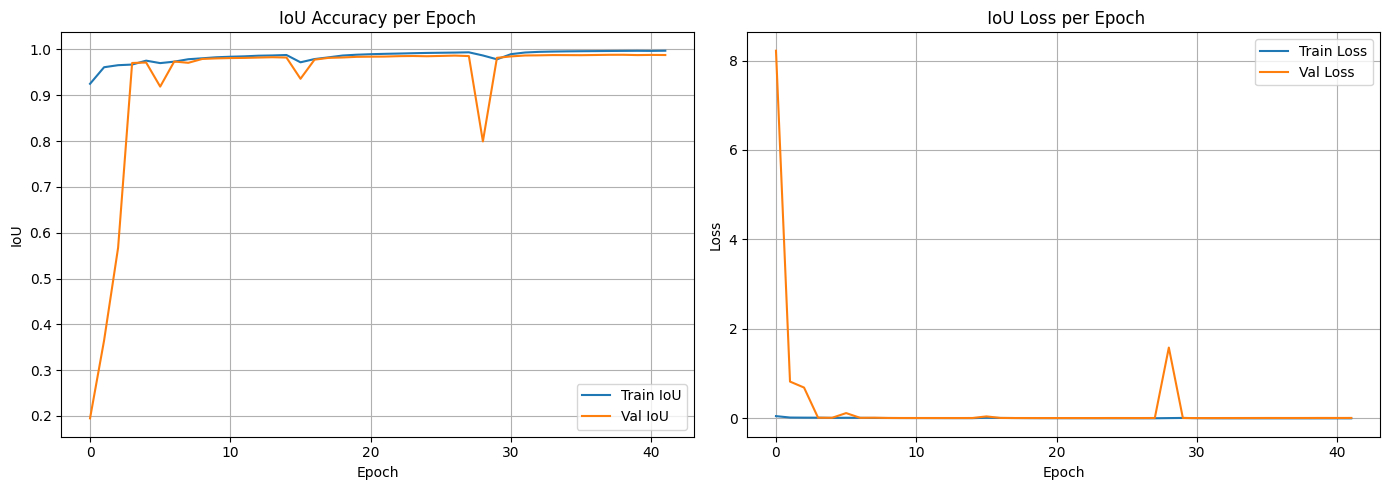

In [ ]:
# Ekstrak data dari history
history_dict = history.history

# Buat plot
plt.figure(figsize=(14, 5))

# Plot IoU (iou_metric)
plt.subplot(1, 2, 1)
plt.plot(history_dict['iou_metric'], label='Train IoU')
plt.plot(history_dict['val_iou_metric'], label='Val IoU')
plt.title('IoU Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title(' IoU Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


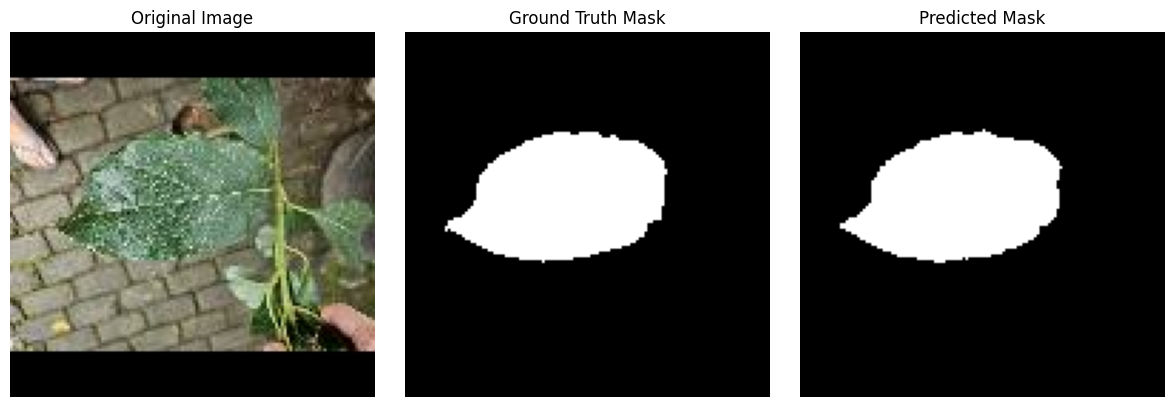

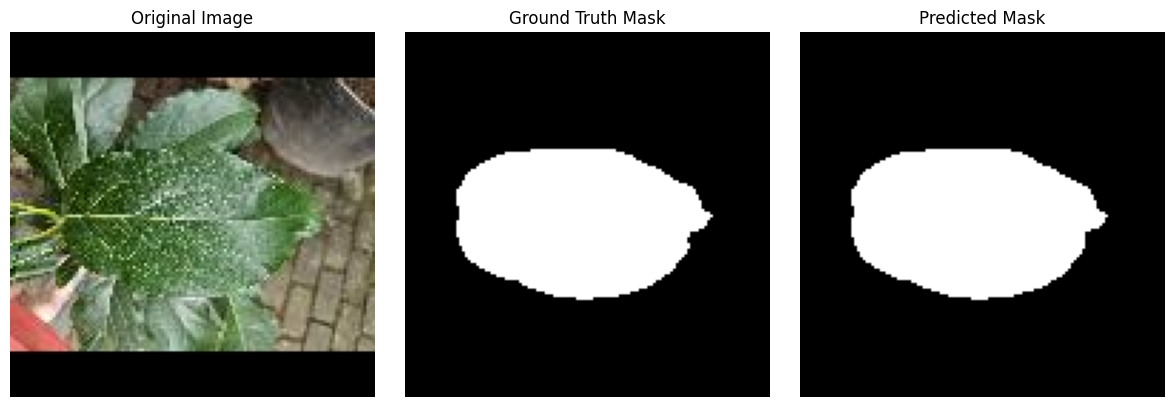

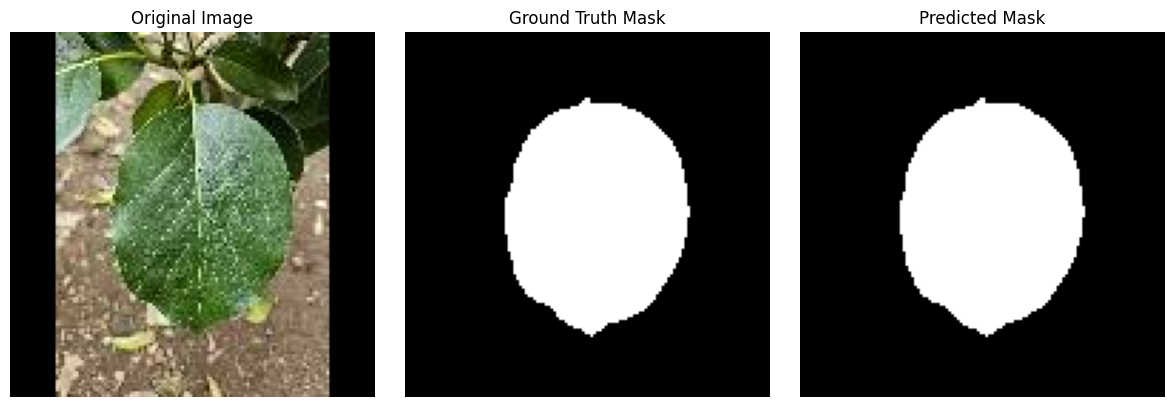

In [ ]:
def display_sample_prediction(model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(model, test_unet_ds, num_samples=3)

##**CLASSIFICATION MODEL**##

In [ ]:
from tensorflow.keras.models import load_model

# Load model U-Net dari checkpoint
unet_model = load_model('/content/drive/MyDrive/alpukat/dataset/best_rsunet01_model.h5')

In [ ]:
import tensorflow as tf

# Mapping string ke angka (lowercase)
reverse_label_map = {v.lower(): k for k, v in label_map.items()}

# TensorFlow lookup table
keys_tensor = tf.constant(list(reverse_label_map.keys()))
vals_tensor = tf.constant(list(reverse_label_map.values()), dtype=tf.int32)

table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
label_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

# Fungsi untuk mengambil label dari nama file
def extract_label_from_filename_tf(filename):
    filename = tf.strings.lower(filename)
    label_str = tf.strings.split(filename, '_')[0]
    return label_table.lookup(label_str)


In [ ]:
def apply_rsunet_segmentation_to_image(image, outputs, threshold=0.5):
    if isinstance(image, tf.Tensor):
        image = tf.cast(image, tf.float32)

    if image.shape[-1] != 3:
        raise ValueError(f"Image must have 3 channels. Got shape: {image.shape}")

    binary_mask = tf.cast(outputs > threshold, tf.float32)
    if len(binary_mask.shape) == 2:
        binary_mask = tf.expand_dims(binary_mask, axis=-1)
    binary_mask_rgb = tf.repeat(binary_mask, repeats=3, axis=-1)

    if binary_mask_rgb.shape != image.shape:
        binary_mask_rgb = tf.image.resize(binary_mask_rgb, image.shape[:2])

    masked_image = image * binary_mask_rgb
    return masked_image

In [ ]:
from tqdm import tqdm
import tensorflow as tf
import os

def save_masked_dataset(image_paths, model, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    for path in tqdm(image_paths):
        # Load image (sudah 128x128 dan normalisasi dilakukan saat load_image_and_label)
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0  # Normalisasi dilakukan sekali saja di sini jika tidak dilakukan sebelumnya

        # Predict mask
        pred = model(tf.expand_dims(image, 0), training=False)
        pred = tf.squeeze(pred, axis=0)

        # Apply mask
        masked_image = apply_rsunet_segmentation_to_image(image, pred)

        # Simpan hasil
        fname = os.path.basename(path)
        save_path = os.path.join(save_dir, fname)
        masked_uint8 = tf.image.convert_image_dtype(masked_image, tf.uint8)
        encoded = tf.image.encode_jpeg(masked_uint8)
        tf.io.write_file(save_path, encoded)

In [ ]:
save_masked_dataset(train_image_paths, model, "maskedrsunet01_train")
save_masked_dataset(test_image_paths, model, "maskedrsunet01_test")

100%|██████████| 1170/1170 [04:58<00:00,  3.93it/s]


In [ ]:
def load_masked_dataset(image_dir):
    image_paths = tf.io.gfile.glob(os.path.join(image_dir, '*.jpg'))
    ds = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_image_and_label(path):
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.cast(image, tf.float32) / 255.0

        filename = tf.strings.split(path, '/')[-1]
        label = extract_label_from_filename_tf(filename)
        return image, label

    return ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Batching dan prefetch
classification_train_ds_16 = load_masked_dataset("maskedrsunet01_train").batch(16).prefetch(tf.data.AUTOTUNE)
classification_test_ds_16 = load_masked_dataset("maskedrsunet01_test").batch(16).prefetch(tf.data.AUTOTUNE)

classification_train_ds_32 = load_masked_dataset("maskedrsunet01_train").batch(32).prefetch(tf.data.AUTOTUNE)
classification_test_ds_32 = load_masked_dataset("maskedrsunet01_test").batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
def classification_model(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    return tf.keras.models.Model(inputs, outputs)

In [ ]:
clf_model_class1 = classification_model()
clf_model_class2 = classification_model()

clf_model_class1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clf_model_class1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

clf_model_class2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Definisikan callbacks
callbacks_class1 = [
    ModelCheckpoint('best_class1_rsunet01.h5', save_best_only=True, monitor='val_loss', mode='min')
]

callbacks_class2 = [
    ModelCheckpoint('best_class2_rsunet01.h5', save_best_only=True, monitor='val_loss', mode='min')
]

##***TRAINING CLASS BS 16***##

In [ ]:
history_class1 = clf_model_class1.fit(
    classification_train_ds_16,   # dataset sudah dibatch dengan batch size 16
    validation_data=classification_test_ds_16,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class1
)

Epoch 1/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3453 - loss: 1.0909

293/293 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - accuracy: 0.3455 - loss: 1.0908 - val_accuracy: 0.5402 - val_loss: 0.9534
Epoch 2/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5776 - loss: 0.9084

293/293 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.5782 - loss: 0.9073 - val_accuracy: 0.7590 - val_loss: 0.5746
Epoch 3/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7461 - loss: 0.5928

293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.7463 - loss: 0.5924 - val_accuracy: 0.7991 - val_loss: 0.4489
Epoch 4/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7856 - loss: 0.4975

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.7856 - loss: 0.4975 - val_accuracy: 0.8162 - val_loss: 0.4216
Epoch 5/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 61ms/step - accuracy: 0.8097 - loss: 0.4519 - val_accuracy: 0.8034 - val_loss: 0.4232
Epoch 6/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8226 - loss: 0.4321

293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 53ms/step - accuracy: 0.8227 - loss: 0.4320 - val_accuracy: 0.8479 - val_loss: 0.3519
Epoch 7/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8415 - loss: 0.3934

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.8415 - loss: 0.3933 - val_accuracy: 0.8607 - val_loss: 0.3260
Epoch 8/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8564 - loss: 0.3635

293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.8564 - loss: 0.3635 - val_accuracy: 0.8709 - val_loss: 0.3171
Epoch 9/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8668 - loss: 0.3489

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.8668 - loss: 0.3489 - val_accuracy: 0.8650 - val_loss: 0.3156
Epoch 10/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8648 - loss: 0.3299

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.8649 - loss: 0.3299 - val_accuracy: 0.8991 - val_loss: 0.2616
Epoch 11/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8721 - loss: 0.3277

293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - accuracy: 0.8721 - loss: 0.3277 - val_accuracy: 0.9068 - val_loss: 0.2523
Epoch 12/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8764 - loss: 0.3109 - val_accuracy: 0.8991 - val_loss: 0.2587
Epoch 13/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8915 - loss: 0.2912

293/293 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.8915 - loss: 0.2911 - val_accuracy: 0.9017 - val_loss: 0.2388
Epoch 14/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9021 - loss: 0.2758

293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9022 - loss: 0.2757 - val_accuracy: 0.9197 - val_loss: 0.2092
Epoch 15/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8924 - loss: 0.2656 - val_accuracy: 0.9179 - val_loss: 0.2104
Epoch 16/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9045 - loss: 0.2535 - val_accuracy: 0.9120 - val_loss: 0.2271
Epoch 17/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9093 - loss: 0.2349

293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9093 - loss: 0.2348 - val_accuracy: 0.9291 - val_loss: 0.1914
Epoch 18/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9146 - loss: 0.2321 - val_accuracy: 0.8795 - val_loss: 0.3138
Epoch 19/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9133 - loss: 0.2279 - val_accuracy: 0.9120 - val_loss: 0.2192
Epoch 20/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9302 - loss: 0.1971

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9302 - loss: 0.1971 - val_accuracy: 0.9350 - val_loss: 0.1868
Epoch 21/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9255 - loss: 0.2062 - val_accuracy: 0.9188 - val_loss: 0.2077
Epoch 22/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9211 - loss: 0.1959

293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9212 - loss: 0.1959 - val_accuracy: 0.9359 - val_loss: 0.1774
Epoch 23/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9400 - loss: 0.1696

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9400 - loss: 0.1696 - val_accuracy: 0.9316 - val_loss: 0.1619
Epoch 24/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9356 - loss: 0.1778 - val_accuracy: 0.9333 - val_loss: 0.1903
Epoch 25/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9326 - loss: 0.1873

293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9326 - loss: 0.1872 - val_accuracy: 0.9325 - val_loss: 0.1602
Epoch 26/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 22s 57ms/step - accuracy: 0.9453 - loss: 0.1576 - val_accuracy: 0.9316 - val_loss: 0.1721
Epoch 27/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9475 - loss: 0.1413

293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9474 - loss: 0.1414 - val_accuracy: 0.9436 - val_loss: 0.1568
Epoch 28/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9493 - loss: 0.1363 - val_accuracy: 0.9436 - val_loss: 0.1657
Epoch 29/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9442 - loss: 0.1522

293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.9442 - loss: 0.1521 - val_accuracy: 0.9427 - val_loss: 0.1380
Epoch 30/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.9536 - loss: 0.1269 - val_accuracy: 0.9487 - val_loss: 0.1591
Epoch 31/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9552 - loss: 0.1352 - val_accuracy: 0.9308 - val_loss: 0.2040
Epoch 32/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step - accuracy: 0.9474 - loss: 0.1551 - val_accuracy: 0.9350 - val_loss: 0.1626
Epoch 33/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 58ms/step - accuracy: 0.9538 - loss: 0.1261 - val_accuracy: 0.9479 - val_loss: 0.1836
Epoch 34/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.9449 - loss: 0.1554 - val_accuracy: 0.9342 - val_loss: 0.1810
Epoch 35/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9617 - loss: 0.1051 - val_accuracy: 0.9427 - val_loss: 0.1888
Epoch 36/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9628 - loss: 0.1167

293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9628 - loss: 0.1166 - val_accuracy: 0.9624 - val_loss: 0.1184
Epoch 37/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.9616 - loss: 0.1056 - val_accuracy: 0.9658 - val_loss: 0.1215
Epoch 38/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.9672 - loss: 0.0875 - val_accuracy: 0.9632 - val_loss: 0.1235
Epoch 39/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9724 - loss: 0.0818 - val_accuracy: 0.9564 - val_loss: 0.1454
Epoch 40/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9733 - loss: 0.0780

293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9733 - loss: 0.0781 - val_accuracy: 0.9573 - val_loss: 0.1138
Epoch 41/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9677 - loss: 0.0924 - val_accuracy: 0.9598 - val_loss: 0.1327
Epoch 42/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9803 - loss: 0.0611 - val_accuracy: 0.9641 - val_loss: 0.1243
Epoch 43/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9777 - loss: 0.0644 - val_accuracy: 0.9496 - val_loss: 0.1353
Epoch 44/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - accuracy: 0.9751 - loss: 0.0777 - val_accuracy: 0.9402 - val_loss: 0.1851
Epoch 45/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9737 - loss: 0.0792 - val_accuracy: 0.9444 - val_loss: 0.1340
Epoch 46/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9721 - loss: 0.0862 - val_accuracy: 0.9590 - val_loss: 0.1330
Epoch 47/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9775 - loss: 0.0634

293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9775 - loss: 0.0634 - val_accuracy: 0.9701 - val_loss: 0.1028
Epoch 48/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9845 - loss: 0.0526 - val_accuracy: 0.9692 - val_loss: 0.1059
Epoch 49/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9837 - loss: 0.0559

293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9837 - loss: 0.0559 - val_accuracy: 0.9726 - val_loss: 0.1026
Epoch 50/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9804 - loss: 0.0519 - val_accuracy: 0.9650 - val_loss: 0.1368
Epoch 51/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9767 - loss: 0.0714

293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9766 - loss: 0.0717 - val_accuracy: 0.9701 - val_loss: 0.0967
Epoch 52/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9877 - loss: 0.0489 - val_accuracy: 0.9632 - val_loss: 0.1265
Epoch 53/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9851 - loss: 0.0525 - val_accuracy: 0.9709 - val_loss: 0.1189
Epoch 54/100
291/293 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9823 - loss: 0.0544

293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9823 - loss: 0.0543 - val_accuracy: 0.9692 - val_loss: 0.0940
Epoch 55/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 49ms/step - accuracy: 0.9909 - loss: 0.0330 - val_accuracy: 0.9530 - val_loss: 0.1679
Epoch 56/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.9802 - loss: 0.0545 - val_accuracy: 0.9701 - val_loss: 0.1056
Epoch 57/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9901 - loss: 0.0348 - val_accuracy: 0.9718 - val_loss: 0.1013
Epoch 58/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 56ms/step - accuracy: 0.9919 - loss: 0.0268 - val_accuracy: 0.9718 - val_loss: 0.1132
Epoch 59/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 18s 48ms/step - accuracy: 0.9895 - loss: 0.0365 - val_accuracy: 0.9692 - val_loss: 0.0949
Epoch 60/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.9915 - loss: 0.0327 - val_accuracy: 0.9607 - val_loss: 0.1109
Epoch 61/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9898 - loss: 0.0333

293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9844 - loss: 0.0521 - val_accuracy: 0.9761 - val_loss: 0.0806
Epoch 70/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9869 - loss: 0.0408 - val_accuracy: 0.9556 - val_loss: 0.1669
Epoch 71/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9883 - loss: 0.0353 - val_accuracy: 0.9735 - val_loss: 0.1211
Epoch 72/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9893 - loss: 0.0315 - val_accuracy: 0.9786 - val_loss: 0.0889
Epoch 73/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.9948 - loss: 0.0166 - val_accuracy: 0.9632 - val_loss: 0.1678
Epoch 74/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.9855 - loss: 0.0449 - val_accuracy: 0.9744 - val_loss: 0.0850
Epoch 75/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9885 - loss: 0.0423 - val_accuracy: 0.9444 - val_loss: 0.1767
Epoch 76/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9923 - loss: 0.0286

293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9849 - loss: 0.0385 - val_accuracy: 0.9803 - val_loss: 0.0792
Epoch 90/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9979 - loss: 0.0087 - val_accuracy: 0.9607 - val_loss: 0.1555
Epoch 91/100
292/293 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9885 - loss: 0.0568

293/293 ━━━━━━━━━━━━━━━━━━━━ 16s 55ms/step - accuracy: 0.9885 - loss: 0.0565 - val_accuracy: 0.9829 - val_loss: 0.0759
Epoch 92/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9944 - loss: 0.0200 - val_accuracy: 0.9761 - val_loss: 0.0944
Epoch 93/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.9884 - loss: 0.0422 - val_accuracy: 0.9786 - val_loss: 0.1020
Epoch 94/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.9971 - loss: 0.0101 - val_accuracy: 0.9829 - val_loss: 0.0987
Epoch 95/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.9973 - loss: 0.0127 - val_accuracy: 0.9795 - val_loss: 0.1088
Epoch 96/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9877 - loss: 0.0369 - val_accuracy: 0.9786 - val_loss: 0.0836
Epoch 97/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.9926 - loss: 0.0198 - val_accuracy: 0.9795 - val_loss: 0.1040
Epoch 98/100
293/293 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.9936 - loss: 0.0178

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

<Figure size 800x600 with 0 Axes>

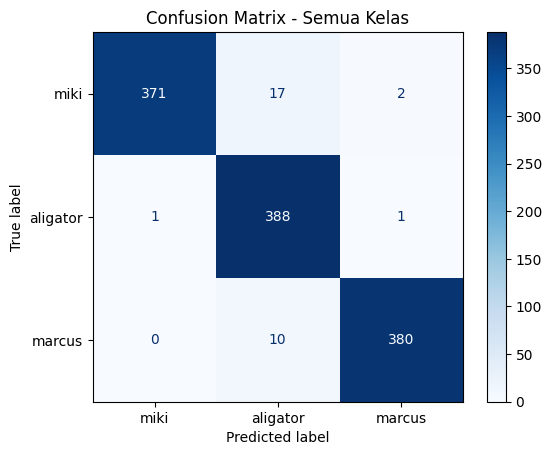

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       1.00      0.95      0.97       390
    aligator       0.93      0.99      0.96       390
      marcus       0.99      0.97      0.98       390

    accuracy                           0.97      1170
   macro avg       0.97      0.97      0.97      1170
weighted avg       0.97      0.97      0.97      1170

              precision    recall  f1-score      support
miki           0.997312  0.951282  0.973753   390.000000
aligator       0.934940  0.994872  0.963975   390.000000
marcus         0.992167  0.974359  0.983182   390.000000
accuracy       0.973504  0.973504  0.973504     0.973504
macro avg      0.974806  0.973504  0.973637  1170.000000
weighted avg   0.974806  0.973504  0.973637  1170.000000


In [ ]:
# Inisialisasi
y_true_all = []
y_pred_all = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_16:
    predictions = clf_model_class1.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all.extend(label_batch.numpy())
    y_pred_all.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
display_labels = [label_map[i] for i in sorted(set(y_true_all + y_pred_all))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all, y_pred_all, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df = pd.DataFrame(
    classification_report(
        y_true_all,
        y_pred_all,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df)

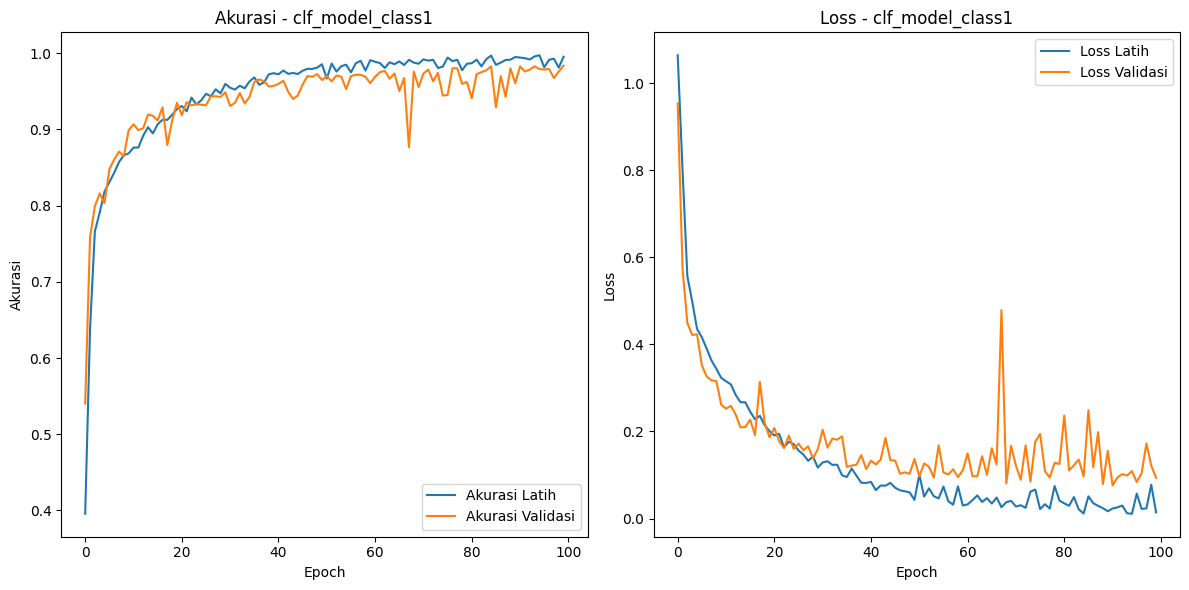

In [ ]:
import matplotlib.pyplot as plt

# Plot History untuk clf_model_class1
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class1
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class1.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class1.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class1.history['loss'], label='Loss Latih')
plt.plot(history_class1.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

##***TRAINING CLASS BS 32***##

In [ ]:
history_class2 = clf_model_class2.fit(
    classification_train_ds_32,   # dataset sudah dibatch dengan batch size 32
    validation_data=classification_test_ds_32,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class2
)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3637 - loss: 1.0905

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.3639 - loss: 1.0903 - val_accuracy: 0.5359 - val_loss: 0.9570
Epoch 2/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5149 - loss: 0.9499

147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.5155 - loss: 0.9491 - val_accuracy: 0.6333 - val_loss: 0.8573
Epoch 3/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6300 - loss: 0.7936

147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.6305 - loss: 0.7927 - val_accuracy: 0.7650 - val_loss: 0.6025
Epoch 4/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7019 - loss: 0.6711

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.7023 - loss: 0.6704 - val_accuracy: 0.7641 - val_loss: 0.5649
Epoch 5/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7386 - loss: 0.5893

147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.7389 - loss: 0.5887 - val_accuracy: 0.8034 - val_loss: 0.4822
Epoch 6/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7879 - loss: 0.5125

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.7881 - loss: 0.5122 - val_accuracy: 0.8393 - val_loss: 0.4152
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.7773 - loss: 0.5213 - val_accuracy: 0.7470 - val_loss: 0.6130
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - accuracy: 0.8011 - loss: 0.4737 - val_accuracy: 0.7256 - val_loss: 0.6316
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 115ms/step - accuracy: 0.8018 - loss: 0.4587 - val_accuracy: 0.7846 - val_loss: 0.5082
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - accuracy: 0.8202 - loss: 0.4415 - val_accuracy: 0.7393 - val_loss: 0.6094
Epoch 11/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8264 - loss: 0.4230

147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.8266 - loss: 0.4225 - val_accuracy: 0.8462 - val_loss: 0.3586
Epoch 12/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.8184 - loss: 0.4443 - val_accuracy: 0.8342 - val_loss: 0.3782
Epoch 13/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8405 - loss: 0.3906

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.8407 - loss: 0.3904 - val_accuracy: 0.8658 - val_loss: 0.3167
Epoch 14/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8526 - loss: 0.3572

147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.8526 - loss: 0.3571 - val_accuracy: 0.8829 - val_loss: 0.2907
Epoch 15/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step - accuracy: 0.8636 - loss: 0.3445 - val_accuracy: 0.8650 - val_loss: 0.3197
Epoch 16/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8581 - loss: 0.3591

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.8582 - loss: 0.3588 - val_accuracy: 0.8966 - val_loss: 0.2769
Epoch 17/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8803 - loss: 0.3184

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.8803 - loss: 0.3183 - val_accuracy: 0.9043 - val_loss: 0.2584
Epoch 18/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.8815 - loss: 0.3087 - val_accuracy: 0.8701 - val_loss: 0.2989
Epoch 19/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8806 - loss: 0.3025

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 96ms/step - accuracy: 0.8807 - loss: 0.3023 - val_accuracy: 0.9060 - val_loss: 0.2514
Epoch 20/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9054 - loss: 0.2677

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9053 - loss: 0.2677 - val_accuracy: 0.9179 - val_loss: 0.2336
Epoch 21/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - accuracy: 0.8912 - loss: 0.2905 - val_accuracy: 0.9051 - val_loss: 0.2590
Epoch 22/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8905 - loss: 0.2927

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.8905 - loss: 0.2925 - val_accuracy: 0.9222 - val_loss: 0.2295
Epoch 23/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9070 - loss: 0.2476

147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.9070 - loss: 0.2476 - val_accuracy: 0.9188 - val_loss: 0.2197
Epoch 24/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accuracy: 0.9095 - loss: 0.2439 - val_accuracy: 0.9137 - val_loss: 0.2272
Epoch 25/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - accuracy: 0.9143 - loss: 0.2321 - val_accuracy: 0.9205 - val_loss: 0.2244
Epoch 26/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.8991 - loss: 0.2500 - val_accuracy: 0.8855 - val_loss: 0.3093
Epoch 27/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9096 - loss: 0.2524

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9096 - loss: 0.2522 - val_accuracy: 0.9350 - val_loss: 0.1899
Epoch 28/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9193 - loss: 0.2090 - val_accuracy: 0.9368 - val_loss: 0.1944
Epoch 29/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.9169 - loss: 0.2093 - val_accuracy: 0.9009 - val_loss: 0.2776
Epoch 30/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 114ms/step - accuracy: 0.9090 - loss: 0.2366 - val_accuracy: 0.9265 - val_loss: 0.1952
Epoch 31/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9279 - loss: 0.1909 - val_accuracy: 0.9205 - val_loss: 0.2101
Epoch 32/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.9332 - loss: 0.1976 - val_accuracy: 0.9265 - val_loss: 0.1922
Epoch 33/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 111ms/step - accuracy: 0.9306 - loss: 0.1794 - val_accuracy: 0.9120 - val_loss: 0.2378
Epoch 34/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9303 - loss: 0.

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9393 - loss: 0.1681 - val_accuracy: 0.9308 - val_loss: 0.1850
Epoch 36/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.9349 - loss: 0.1646 - val_accuracy: 0.8855 - val_loss: 0.3281
Epoch 37/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 113ms/step - accuracy: 0.9308 - loss: 0.1883 - val_accuracy: 0.9085 - val_loss: 0.2676
Epoch 38/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9246 - loss: 0.1766

147/147 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.9247 - loss: 0.1764 - val_accuracy: 0.9453 - val_loss: 0.1631
Epoch 39/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9484 - loss: 0.1406

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9484 - loss: 0.1406 - val_accuracy: 0.9462 - val_loss: 0.1548
Epoch 40/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - accuracy: 0.9440 - loss: 0.1449 - val_accuracy: 0.8581 - val_loss: 0.4816
Epoch 41/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 102ms/step - accuracy: 0.9297 - loss: 0.1804 - val_accuracy: 0.9436 - val_loss: 0.1591
Epoch 42/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.9467 - loss: 0.1424 - val_accuracy: 0.9368 - val_loss: 0.1656
Epoch 43/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - accuracy: 0.9484 - loss: 0.1348 - val_accuracy: 0.9359 - val_loss: 0.1827
Epoch 44/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9365 - loss: 0.1515

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9365 - loss: 0.1514 - val_accuracy: 0.9462 - val_loss: 0.1535
Epoch 45/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9521 - loss: 0.1396

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 114ms/step - accuracy: 0.9521 - loss: 0.1395 - val_accuracy: 0.9538 - val_loss: 0.1399
Epoch 46/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - accuracy: 0.9510 - loss: 0.1292 - val_accuracy: 0.9462 - val_loss: 0.1443
Epoch 47/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9578 - loss: 0.1236

147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.9578 - loss: 0.1235 - val_accuracy: 0.9496 - val_loss: 0.1358
Epoch 48/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 112ms/step - accuracy: 0.9566 - loss: 0.1231 - val_accuracy: 0.9547 - val_loss: 0.1375
Epoch 49/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.9532 - loss: 0.1276 - val_accuracy: 0.9513 - val_loss: 0.1404
Epoch 50/100
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9611 - loss: 0.1107

147/147 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.9611 - loss: 0.1107 - val_accuracy: 0.9573 - val_loss: 0.1247
Epoch 51/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.9522 - loss: 0.1236 - val_accuracy: 0.9385 - val_loss: 0.1652
Epoch 52/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.9606 - loss: 0.1086 - val_accuracy: 0.9436 - val_loss: 0.1921
Epoch 53/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - accuracy: 0.9572 - loss: 0.1182 - val_accuracy: 0.9556 - val_loss: 0.1532
Epoch 54/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.9552 - loss: 0.1165 - val_accuracy: 0.9615 - val_loss: 0.1319
Epoch 55/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.9645 - loss: 0.0923 - val_accuracy: 0.9650 - val_loss: 0.1323
Epoch 56/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9635 - loss: 0.0933 - val_accuracy: 0.9479 - val_loss: 0.1525
Epoch 57/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.9528 - loss: 0.

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9610 - loss: 0.1045 - val_accuracy: 0.9632 - val_loss: 0.1148
Epoch 60/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 91ms/step - accuracy: 0.9700 - loss: 0.0841 - val_accuracy: 0.9624 - val_loss: 0.1295
Epoch 61/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9533 - loss: 0.1197 - val_accuracy: 0.9590 - val_loss: 0.1290
Epoch 62/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.9721 - loss: 0.0777 - val_accuracy: 0.9564 - val_loss: 0.1420
Epoch 63/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 93ms/step - accuracy: 0.9686 - loss: 0.0816 - val_accuracy: 0.9624 - val_loss: 0.1200
Epoch 64/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9750 - loss: 0.0683 - val_accuracy: 0.9453 - val_loss: 0.1657
Epoch 65/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9751 - loss: 0.0713 - val_accuracy: 0.9504 - val_loss: 0.1587
Epoch 66/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9730 - loss: 0.0751

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9847 - loss: 0.0485 - val_accuracy: 0.9718 - val_loss: 0.1113
Epoch 70/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9658 - loss: 0.0951 - val_accuracy: 0.9650 - val_loss: 0.1281
Epoch 71/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - accuracy: 0.9812 - loss: 0.0559 - val_accuracy: 0.9615 - val_loss: 0.1441
Epoch 72/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9729 - loss: 0.0812 - val_accuracy: 0.9675 - val_loss: 0.1224
Epoch 73/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 92ms/step - accuracy: 0.9752 - loss: 0.0624 - val_accuracy: 0.9556 - val_loss: 0.1489
Epoch 74/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9798 - loss: 0.0569 - val_accuracy: 0.9701 - val_loss: 0.1204
Epoch 75/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.9806 - loss: 0.0512 - val_accuracy: 0.9684 - val_loss: 0.1363
Epoch 76/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9837 - loss: 0.0533

147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.9743 - loss: 0.0710 - val_accuracy: 0.9752 - val_loss: 0.1024
Epoch 79/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9780 - loss: 0.0633 - val_accuracy: 0.9641 - val_loss: 0.1177
Epoch 80/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.9839 - loss: 0.0498 - val_accuracy: 0.9769 - val_loss: 0.1078
Epoch 81/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9879 - loss: 0.0413 - val_accuracy: 0.9658 - val_loss: 0.1253
Epoch 82/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - accuracy: 0.9836 - loss: 0.0559 - val_accuracy: 0.9718 - val_loss: 0.1151
Epoch 83/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - accuracy: 0.9868 - loss: 0.0408 - val_accuracy: 0.9632 - val_loss: 0.1637
Epoch 84/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.9718 - loss: 0.0761 - val_accuracy: 0.9632 - val_loss: 0.1262
Epoch 85/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - accuracy: 0.9837 - loss: 0.0

147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.9860 - loss: 0.0487 - val_accuracy: 0.9718 - val_loss: 0.0997
Epoch 90/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.9841 - loss: 0.0462 - val_accuracy: 0.9786 - val_loss: 0.1009
Epoch 91/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 121ms/step - accuracy: 0.9920 - loss: 0.0276 - val_accuracy: 0.9752 - val_loss: 0.1090
Epoch 92/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.9903 - loss: 0.0305 - val_accuracy: 0.9761 - val_loss: 0.1153
Epoch 93/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.9869 - loss: 0.0400 - val_accuracy: 0.9632 - val_loss: 0.1273
Epoch 94/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.9910 - loss: 0.0306 - val_accuracy: 0.9496 - val_loss: 0.1284
Epoch 95/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - accuracy: 0.9792 - loss: 0.0589 - val_accuracy: 0.9624 - val_loss: 0.1339
Epoch 96/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9828 - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━

<Figure size 800x600 with 0 Axes>

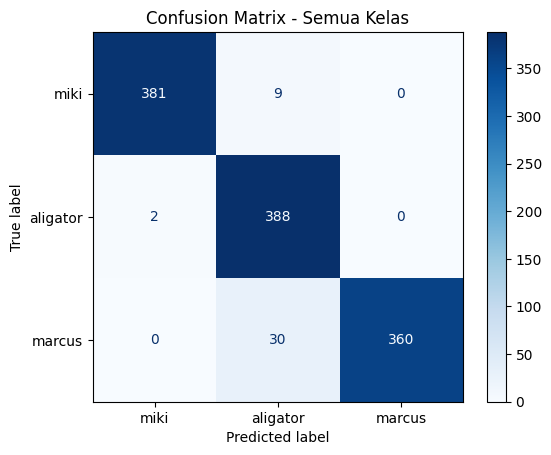

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       0.99      0.98      0.99       390
    aligator       0.91      0.99      0.95       390
      marcus       1.00      0.92      0.96       390

    accuracy                           0.96      1170
   macro avg       0.97      0.96      0.97      1170
weighted avg       0.97      0.96      0.97      1170

              precision    recall  f1-score      support
miki           0.994778  0.976923  0.985770   390.000000
aligator       0.908665  0.994872  0.949816   390.000000
marcus         1.000000  0.923077  0.960000   390.000000
accuracy       0.964957  0.964957  0.964957     0.964957
macro avg      0.967814  0.964957  0.965195  1170.000000
weighted avg   0.967814  0.964957  0.965195  1170.000000


In [ ]:
# Inisialisasi
y_true_all2 = []
y_pred_all2 = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_32:
    predictions = clf_model_class2.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all2.extend(label_batch.numpy())
    y_pred_all2.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all2, y_pred_all2)
display_labels = [label_map[i] for i in sorted(set(y_true_all2 + y_pred_all2))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all2, y_pred_all2, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df2 = pd.DataFrame(
    classification_report(
        y_true_all2,
        y_pred_all2,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df2)

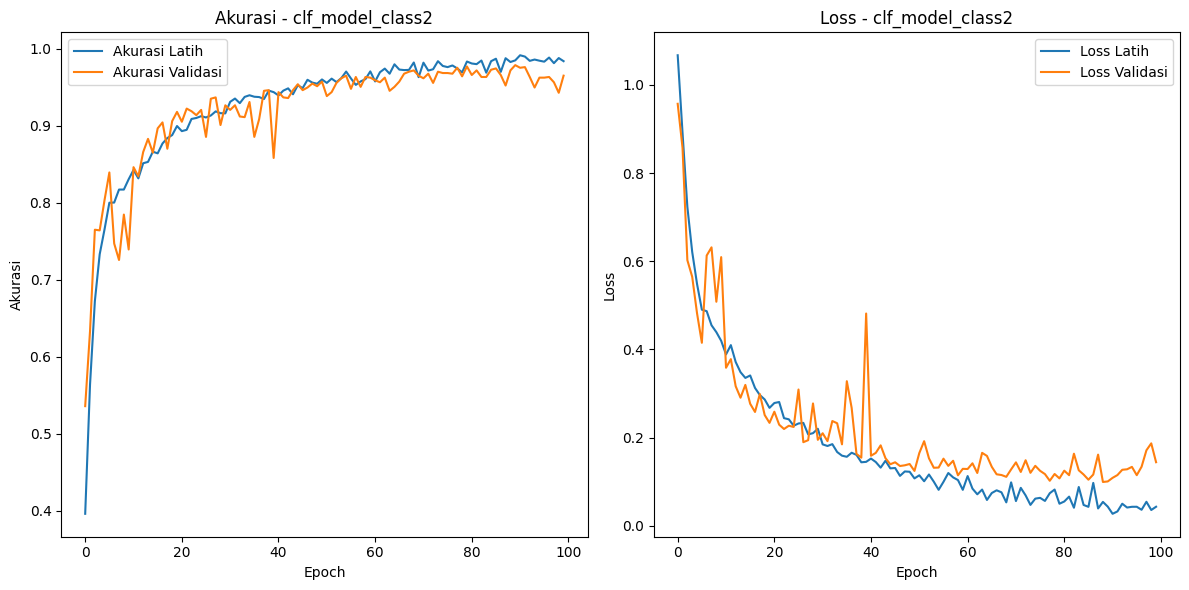

In [ ]:
# Plot History untuk clf_model_class2
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class2
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class2.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class2.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class2.history['loss'], label='Loss Latih')
plt.plot(history_class2.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


##**VISUALISASI AKHIR**##

In [ ]:
def visualize_all_test_images(image_paths, mask_paths, labels, masked_image_paths, clf_model_class1, label_map, max_visualize=None):
    label_names = label_map
    num_samples = len(image_paths)

    if max_visualize is not None:
        num_samples = min(num_samples, max_visualize)

    for i in range(num_samples):
        image_path = image_paths[i]
        mask_path = mask_paths[i]
        masked_image_path = masked_image_paths[i]
        true_label_idx = labels[i]

        # Load original image
        image_raw = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0

        # Load ground truth mask (if available)
        try:
            mask_raw = tf.io.read_file(mask_path)
            gt_mask = tf.image.decode_jpeg(mask_raw, channels=1)
            gt_mask = tf.image.resize(gt_mask, [128, 128])
            gt_mask = tf.cast(gt_mask, tf.float32)
        except:
            gt_mask = tf.zeros((128, 128, 1), dtype=tf.float32)

        # Load masked image (hasil segmentasi offline)
        masked_image_raw = tf.io.read_file(masked_image_path)
        masked_image = tf.image.decode_jpeg(masked_image_raw, channels=3)
        masked_image = tf.image.resize(masked_image, [128, 128])
        masked_image = tf.cast(masked_image, tf.float32) / 255.0

        # Predict label with classifier
        pred_probs = clf_model_class1(tf.expand_dims(masked_image, 0), training=False)
        pred_label_idx = int(tf.argmax(pred_probs, axis=-1).numpy()[0])

        # Convert label index to string
        true_label_str = label_names.get(true_label_idx, f"Unknown ({true_label_idx})")
        pred_label_str = label_names.get(pred_label_idx, f"Unknown ({pred_label_idx})")

        # Visualisasi
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        axes[0].imshow(image.numpy())
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(gt_mask, cmap='gray')
        axes[1].set_title("Ground Truth Mask")
        axes[1].axis('off')

        axes[2].imshow(masked_image.numpy())
        axes[2].set_title("Masked Image (Hasil Segmentasi)")
        axes[2].axis('off')

        axes[3].imshow(masked_image.numpy())
        axes[3].set_title(f"Label Asli: {true_label_str}\nPrediksi: {pred_label_str}")
        axes[3].axis('off')

        filename = os.path.basename(image_path)
        plt.suptitle(f"Visualisasi: {filename}", fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()


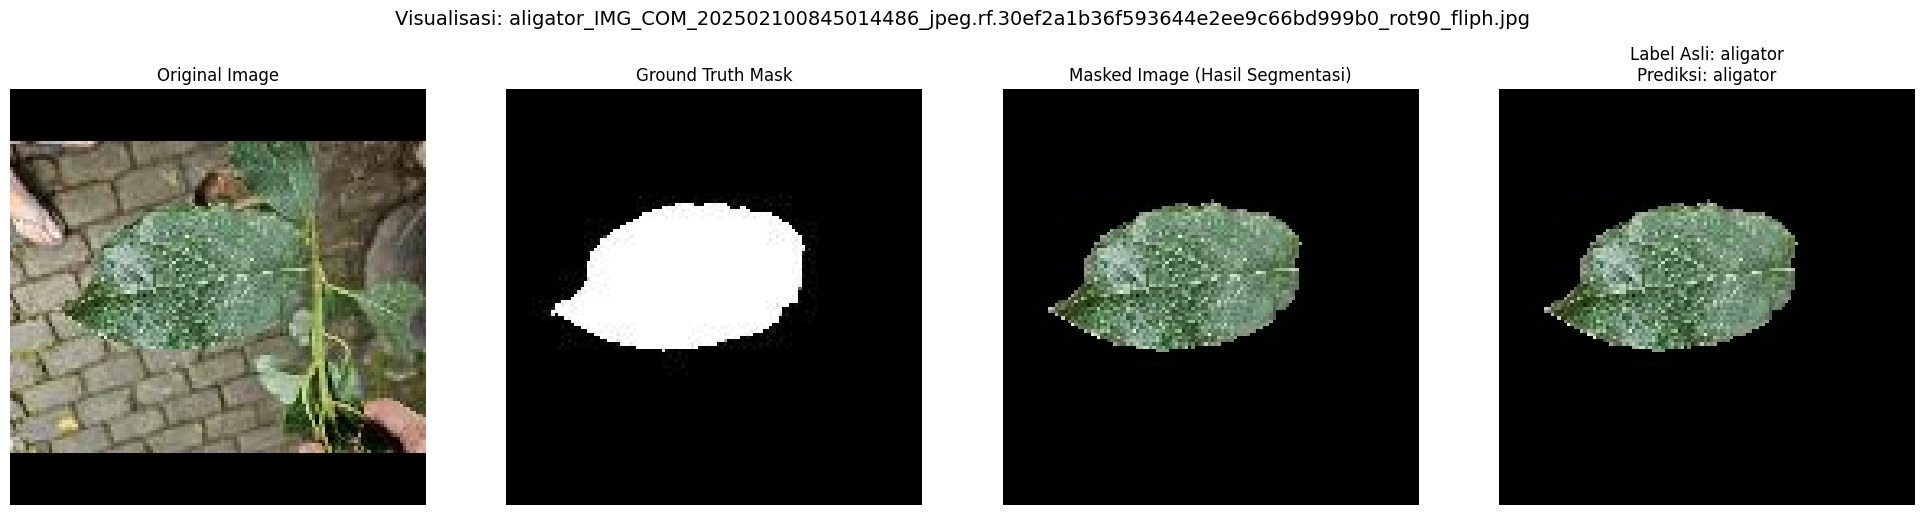

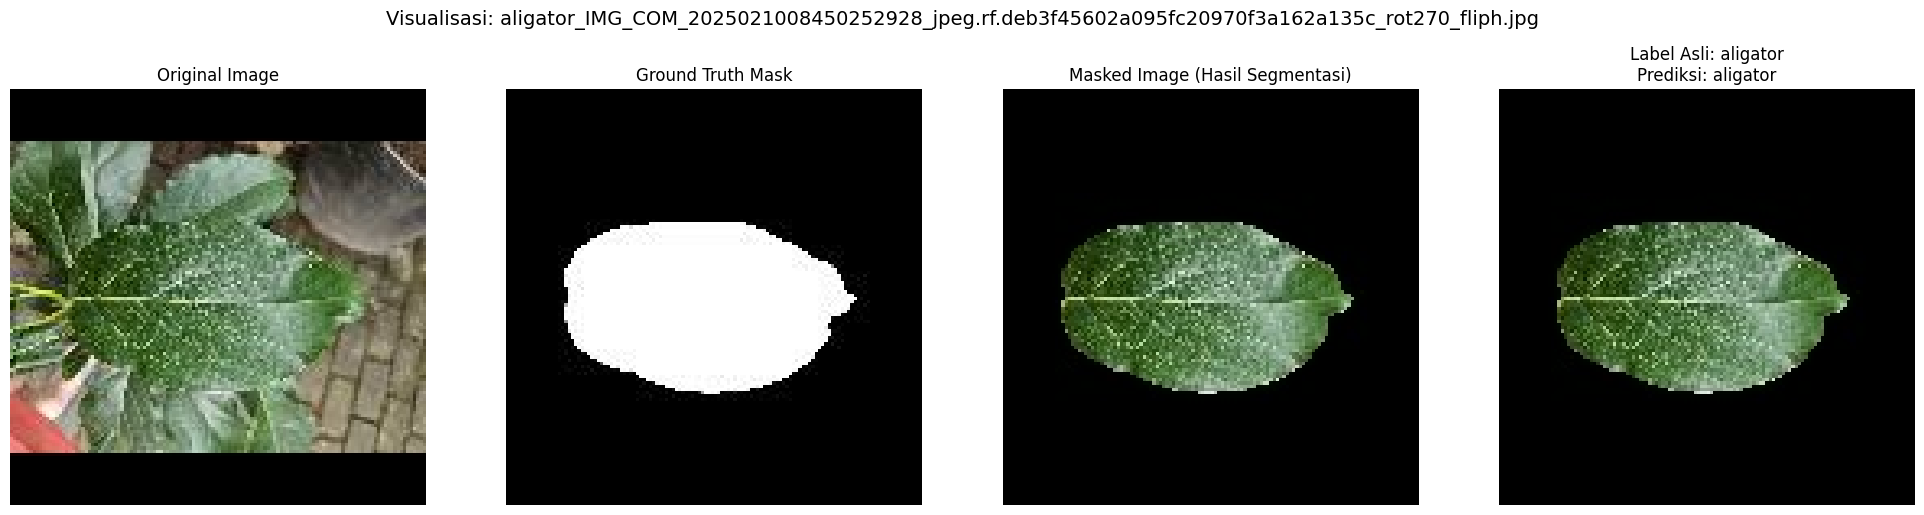

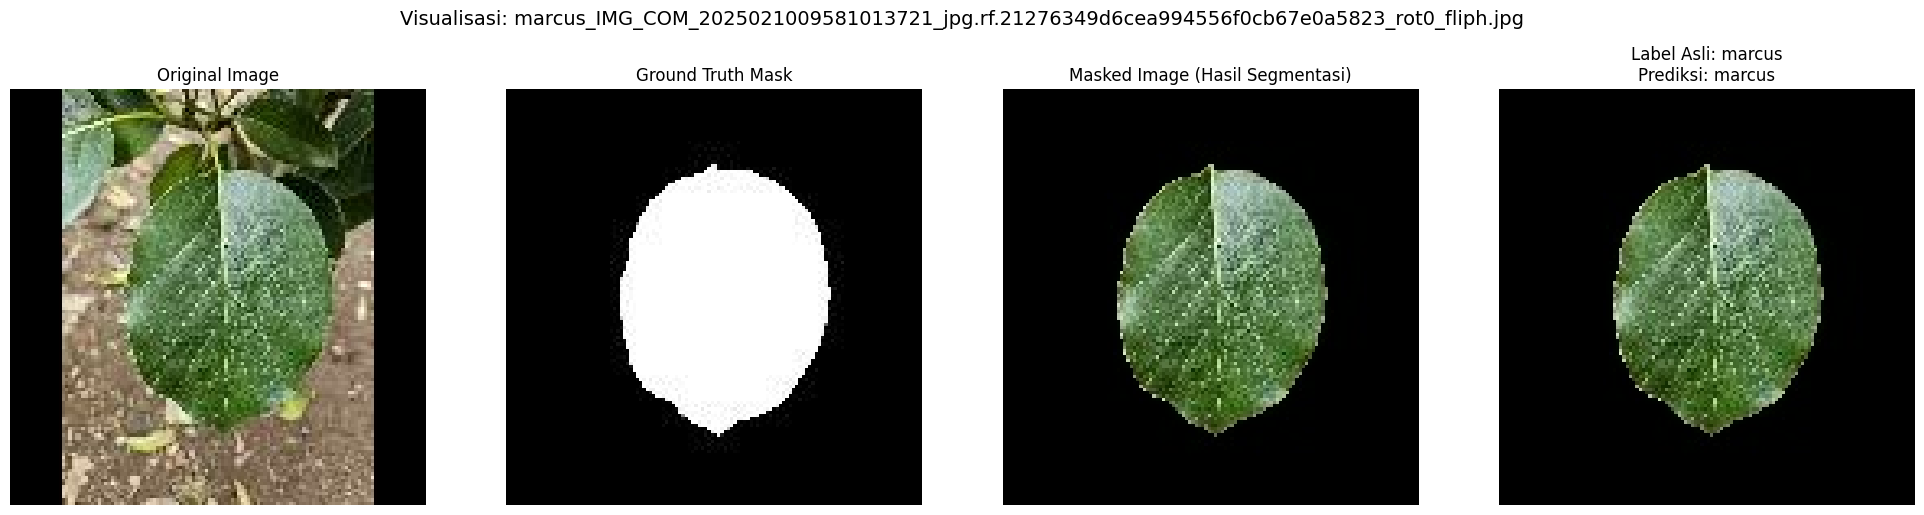

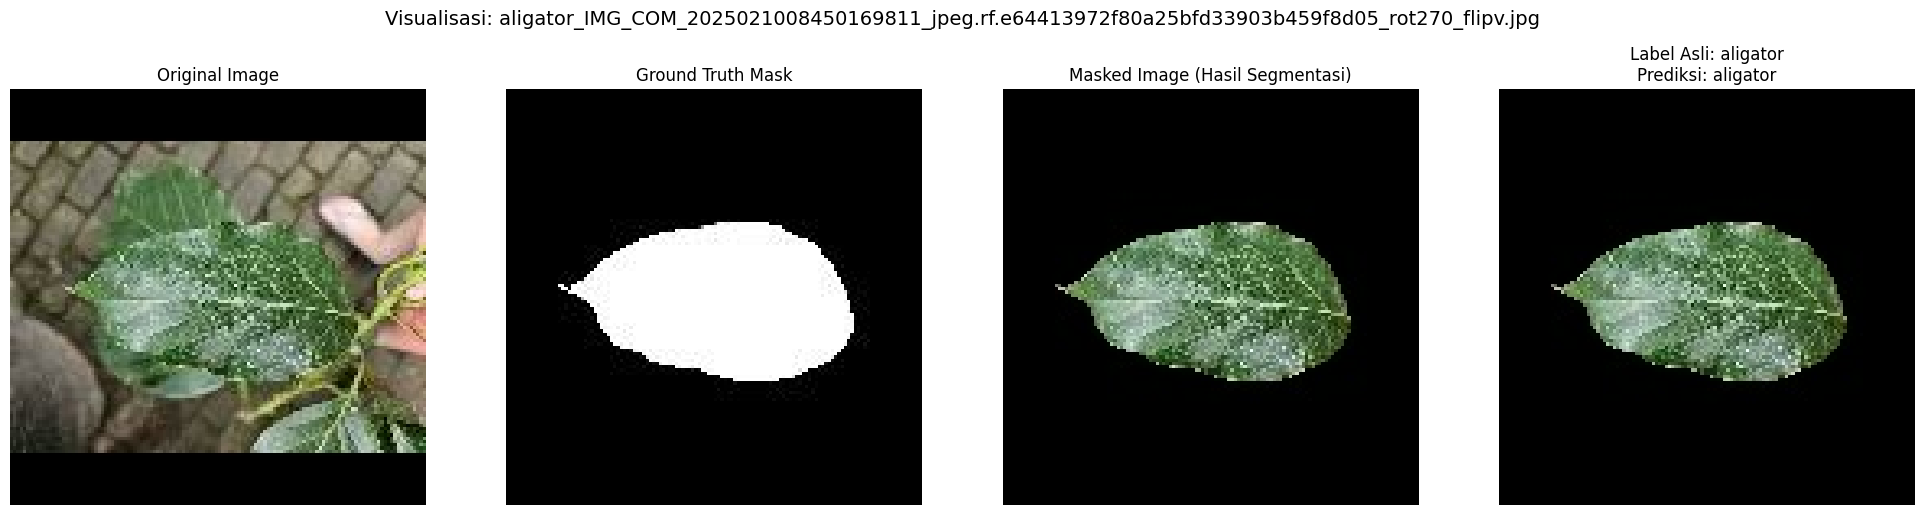

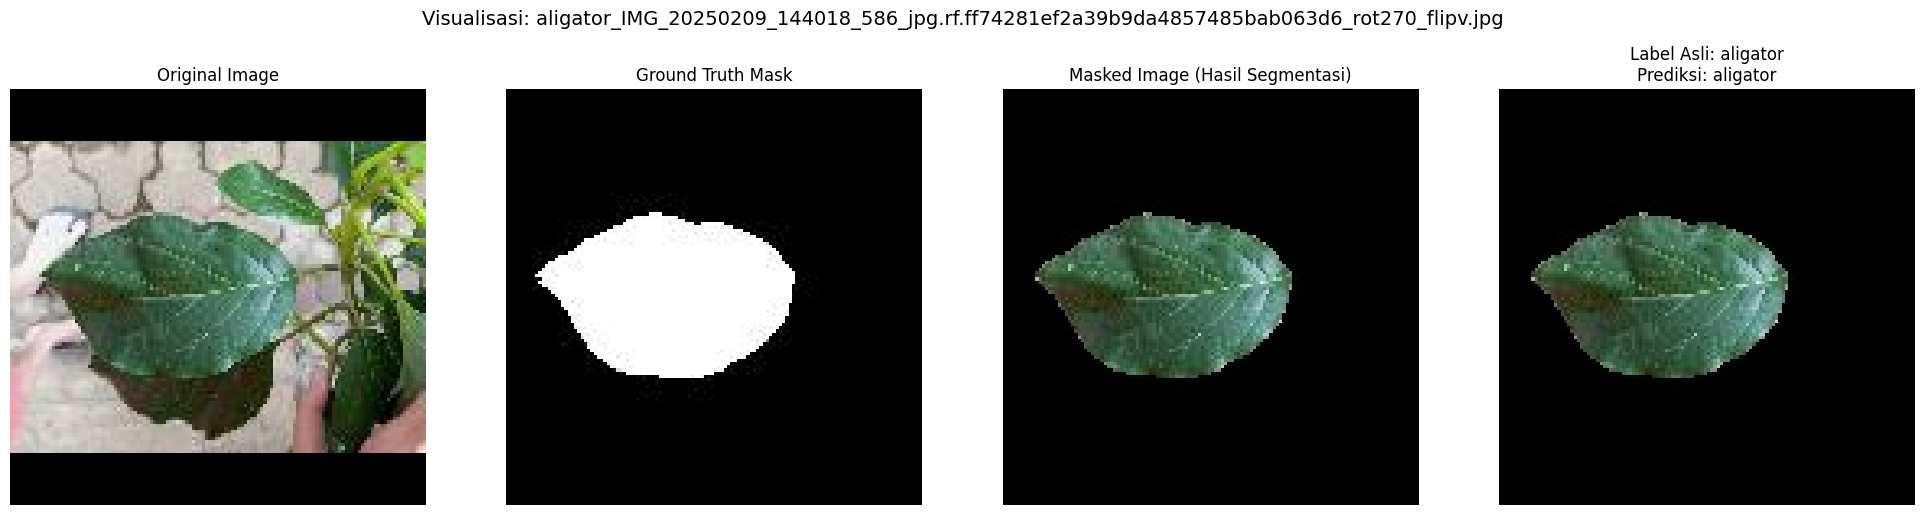

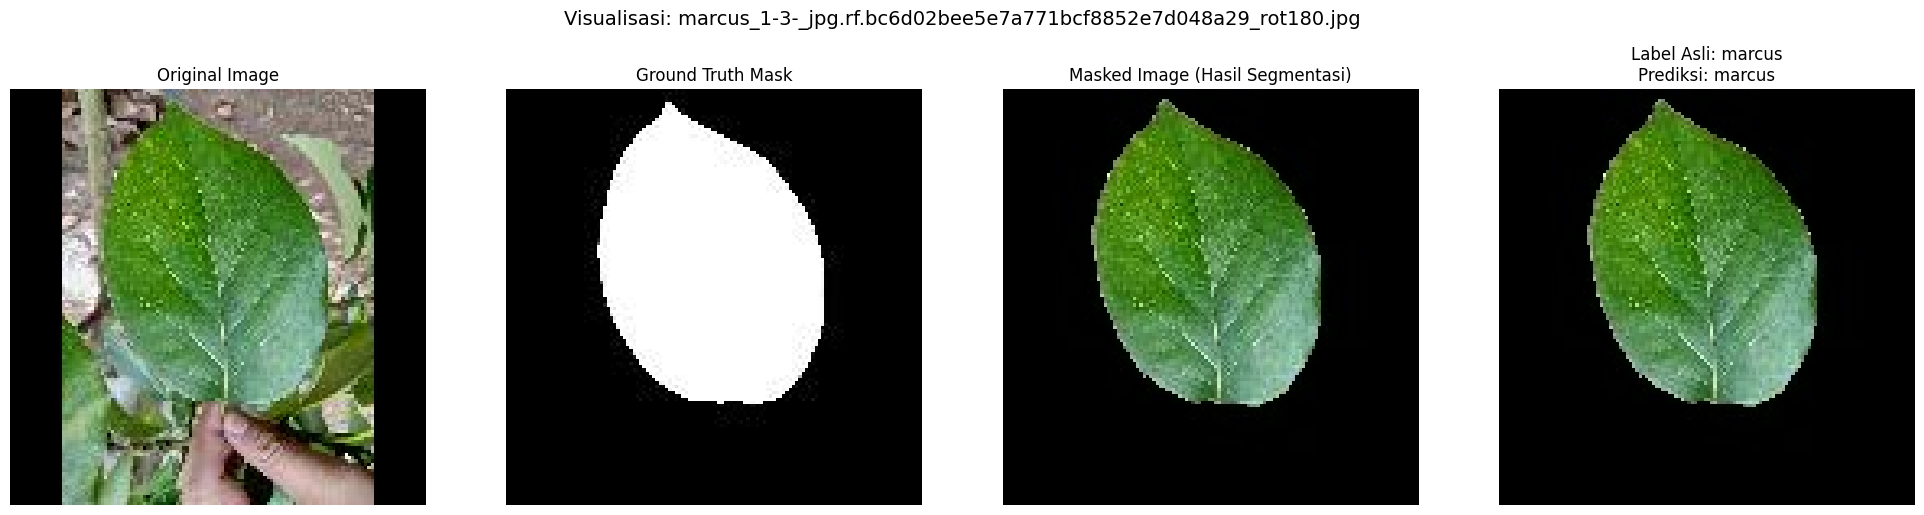

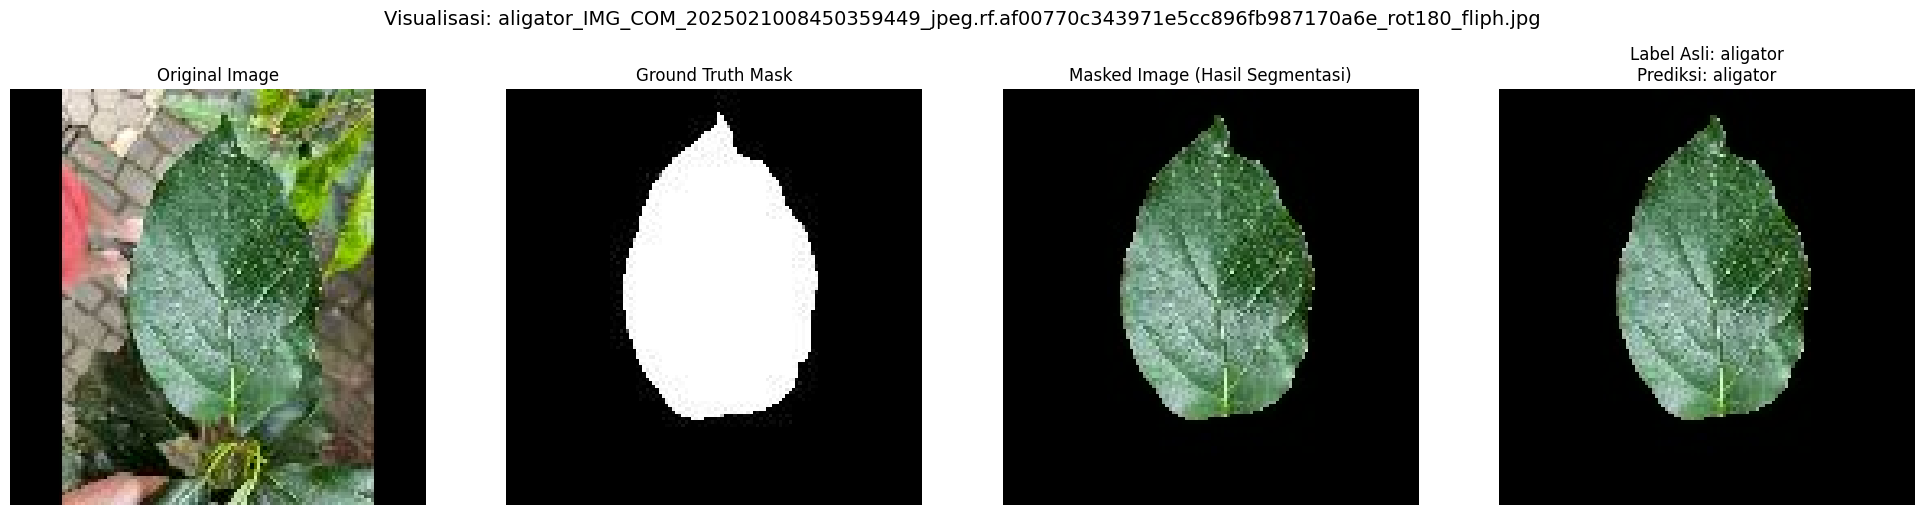

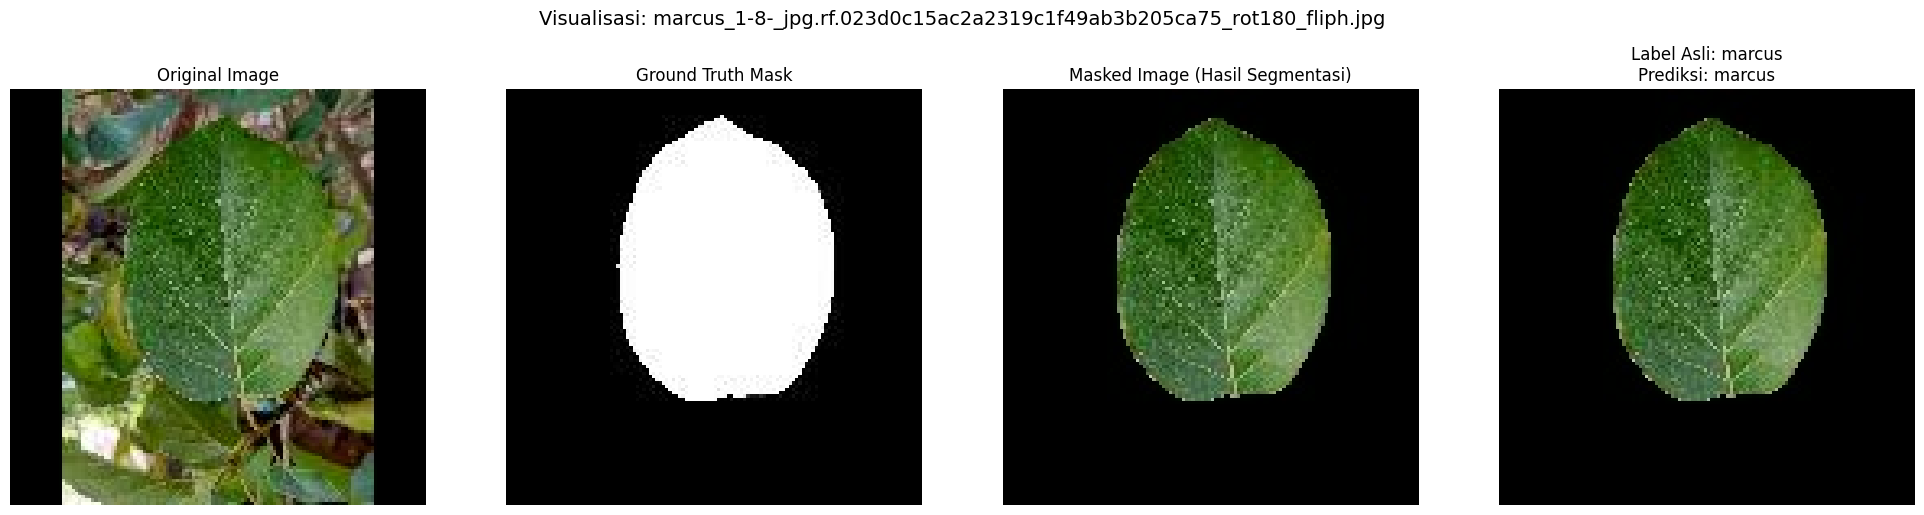

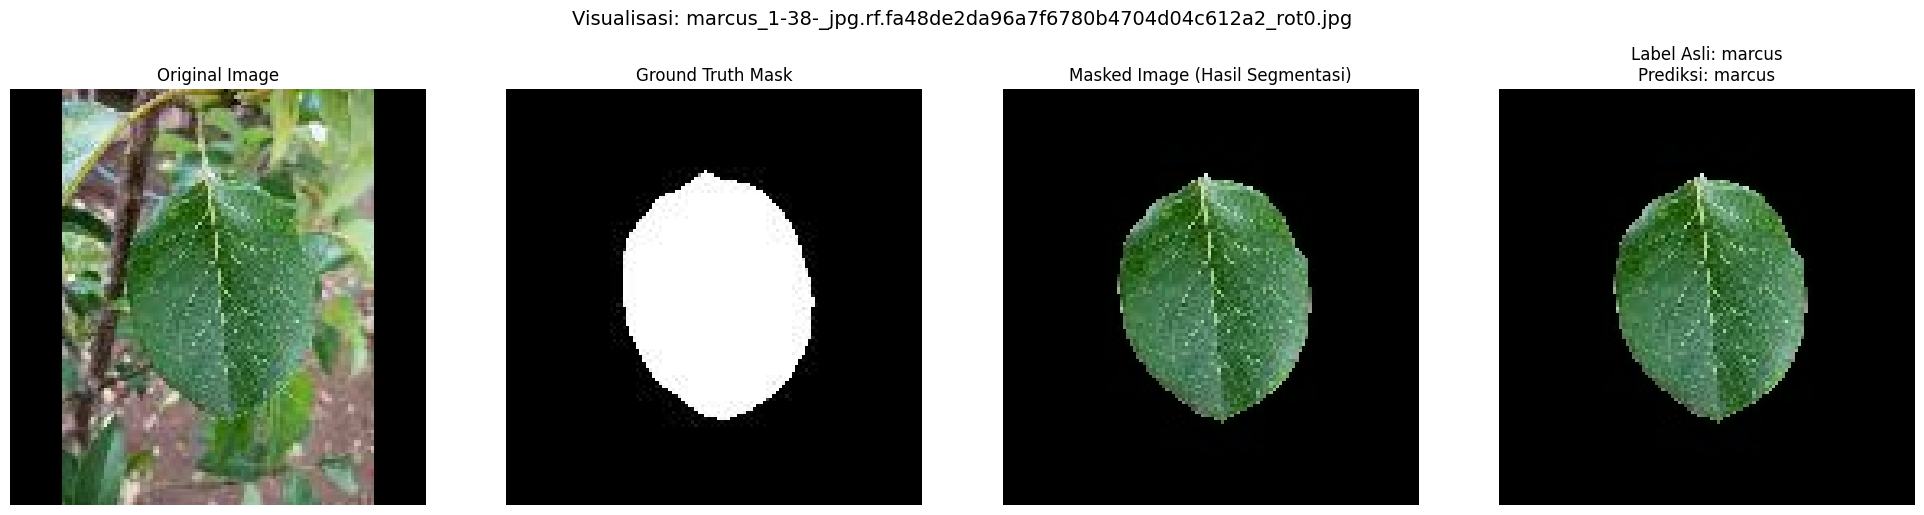

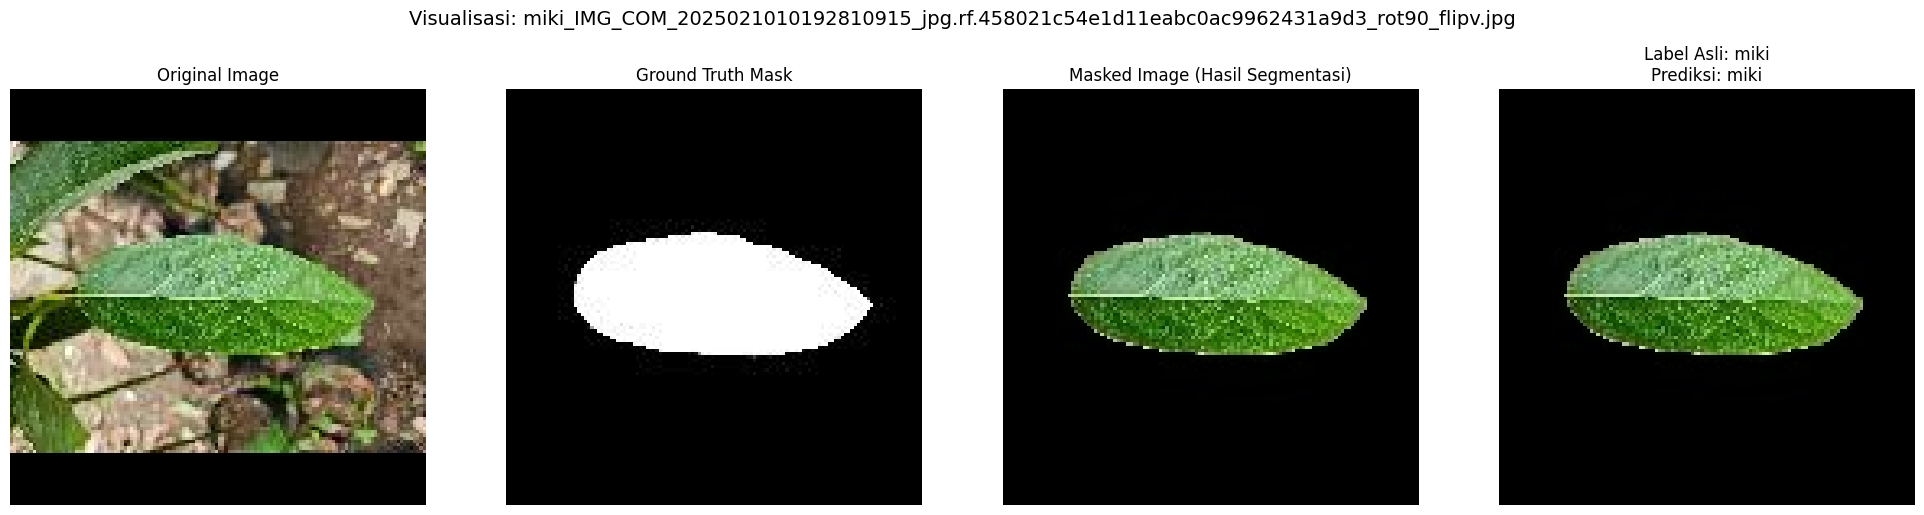

In [ ]:
visualize_all_test_images(
    image_paths=test_image_paths,
    mask_paths=test_mask_paths,
    labels=test_labels,
    masked_image_paths=[os.path.join("maskedrsunet01_test", os.path.basename(p)) for p in test_image_paths],  # list of saved masked image filepaths
    clf_model_class1=clf_model_class1,
    label_map=label_map,
    max_visualize=10
)